<a href="https://colab.research.google.com/github/kthanikonda/Privacy-Aware-Computing/blob/main/Privacy_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests beautifulsoup4 lxml

In [ ]:
# Extracted the privacy policy from google

import requests
from bs4 import BeautifulSoup
import pandas as pd

# List of company privacy policy URLs
COMPANY_URLS = {
    "Google": "https://policies.google.com/privacy",
    # Add more companies: "Facebook": "https://www.facebook.com/privacy/policy/"
}

def extract_privacy_policy(url):
    """Extracts text from a privacy policy page."""
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to retrieve {url}")
        return None

    soup = BeautifulSoup(response.text, "lxml")
    paragraphs = soup.find_all(['p', 'h2'])
    policy_text = "\n".join([p.get_text() for p in paragraphs])

    return policy_text.strip()

# Extract privacy policies for each company
privacy_policies = {}
for company, url in COMPANY_URLS.items():
    privacy_policies[company] = extract_privacy_policy(url)

print("Privacy Policies Extracted!")



Privacy Policies Extracted!


In [ ]:
# Use spaCy for tokenization (splitting text into words and sentences)
!pip install spacy
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Preprocess Privacy Policy

import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    """Tokenizes and cleans privacy policy text."""
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return " ".join(sentences)  # Convert back to a single cleaned text

# Apply preprocessing
for company in privacy_policies:
    privacy_policies[company] = preprocess_text(privacy_policies[company])

print("Text Preprocessing Complete!")



Text Preprocessing Complete!


In [ ]:
# List of ambiguous words and legal jargon
AMBIGUOUS_TERMS = ["may", "could", "might", "possibly", "generally", "some"]
LEGAL_JARGON = ["affiliates", "disclosure", "opt-in", "opt-out", "third party", "arbitration"]

def analyze_deception(text):
    """Detects ambiguous terms, legal jargon, and passive voice usage."""
    doc = nlp(text)

    ambiguous_count = sum(1 for token in doc if token.text.lower() in AMBIGUOUS_TERMS)
    legal_jargon_count = sum(1 for token in doc if token.text.lower() in LEGAL_JARGON)

    passive_voice_count = sum(1 for sent in doc.sents if any(
        token.dep_ == 'aux' and token.head.pos_ == 'VERB' for token in sent))

    return {
        "Ambiguous Terms": ambiguous_count,
        "Legal Jargon": legal_jargon_count,
        "Passive Voice Sentences": passive_voice_count
    }

# Compute deception scores
deception_scores = {company: analyze_deception(privacy_policies[company]) for company in privacy_policies}

print("Deception Score Analysis Complete!")


Deception Score Analysis Complete!


In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.6 MB/s eta 0:00:00


In [ ]:
import textstat

def analyze_readability(text):
    """Calculates readability scores."""
    return {
        "Flesch Reading Ease": textstat.flesch_reading_ease(text),
        "Flesch-Kincaid Grade Level": textstat.flesch_kincaid_grade(text),
        "Gunning Fog Index": textstat.gunning_fog(text)
    }

# Compute readability scores
readability_scores = {company: analyze_readability(privacy_policies[company]) for company in privacy_policies}

print("Readability Analysis Complete!")


Readability Analysis Complete!


In [ ]:
import random
from nltk.corpus import wordnet

def get_synonym(word):
    """Returns a synonym for a word using WordNet."""
    synonyms = wordnet.synsets(word)
    if synonyms:
        synonym = synonyms[0].lemmas()[0].name()
        return synonym.replace("_", " ")  # Replace underscores with spaces
    return word

def apply_dp_modifications(text):
    """Applies word substitutions, random deletions, and sentence shuffling."""

    def substitute_words(sentence):
        words = sentence.split()
        return " ".join([get_synonym(w) if w in AMBIGUOUS_TERMS else w for w in words])

    def delete_random_words(sentence, prob=0.15):
        words = sentence.split()
        return " ".join([word for word in words if random.random() > prob])

    modified_sentences = [delete_random_words(substitute_words(sent)) for sent in text.split(". ")]
    random.shuffle(modified_sentences)

    return ". ".join(modified_sentences)

# Apply DP modifications
dp_policies = {company: apply_dp_modifications(privacy_policies[company]) for company in privacy_policies}

print("DP-Based Privacy Policy Sanitization Complete!")


DP-Based Privacy Policy Sanitization Complete!


In [ ]:
# Prepare data for CSV
data = []

for company, url in COMPANY_URLS.items():
    row = {
        "Company": company,
        "URL": url,
        "Original Policy": privacy_policies[company],
        "Flesch Reading Ease": readability_scores[company]["Flesch Reading Ease"],
        "Flesch-Kincaid Grade Level": readability_scores[company]["Flesch-Kincaid Grade Level"],
        "Gunning Fog Index": readability_scores[company]["Gunning Fog Index"],
        "Ambiguous Terms": deception_scores[company]["Ambiguous Terms"],
        "Legal Jargon": deception_scores[company]["Legal Jargon"],
        "Passive Voice Sentences": deception_scores[company]["Passive Voice Sentences"],
        "DP-Modified Policy": dp_policies[company]
    }
    data.append(row)

# Save to CSV
df = pd.DataFrame(data)
df.to_csv("privacy_policy_analysis.csv", index=False, encoding="utf-8")

print("Results saved to privacy_policy_analysis.csv!")


Results saved to privacy_policy_analysis.csv!


<Figure size 1200x600 with 0 Axes>

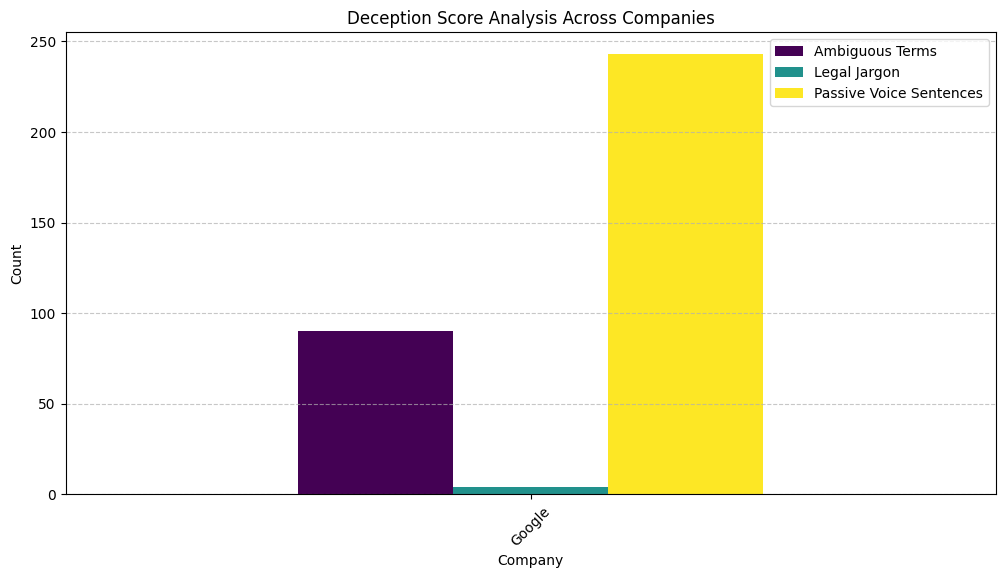

<Figure size 1200x600 with 0 Axes>

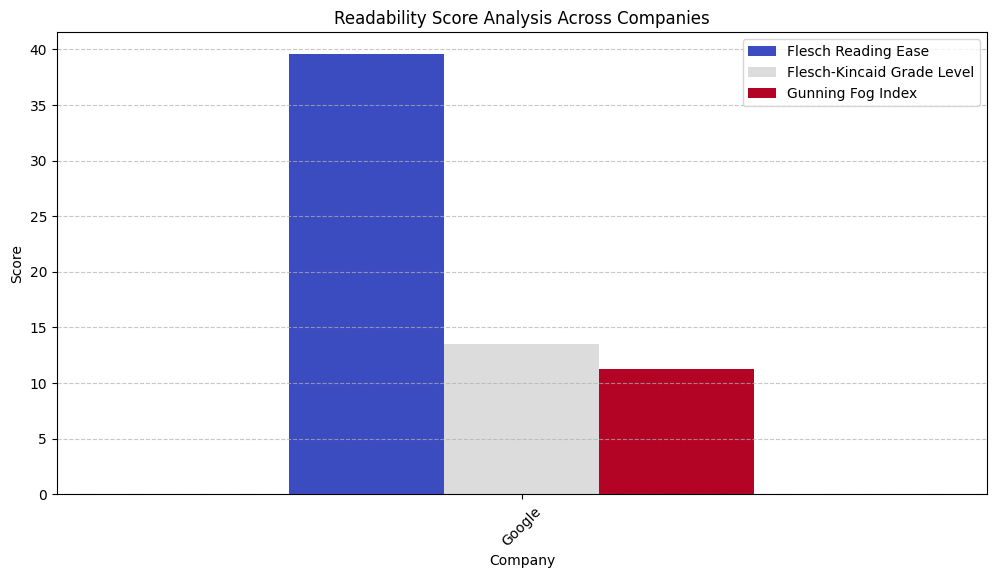

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the saved CSV file
df = pd.read_csv("privacy_policy_analysis.csv")

# Set plot size
plt.figure(figsize=(12, 6))

# Bar chart for Deception Scores
df.plot(
    x="Company",
    y=["Ambiguous Terms", "Legal Jargon", "Passive Voice Sentences"],
    kind="bar",
    figsize=(12, 6),
    title="Deception Score Analysis Across Companies",
    ylabel="Count",
    xlabel="Company",
    legend=True,
    colormap="viridis"
)

# Show the plot
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Readability Analysis Visualization
plt.figure(figsize=(12, 6))
df.plot(
    x="Company",
    y=["Flesch Reading Ease", "Flesch-Kincaid Grade Level", "Gunning Fog Index"],
    kind="bar",
    figsize=(12, 6),
    title="Readability Score Analysis Across Companies",
    ylabel="Score",
    xlabel="Company",
    legend=True,
    colormap="coolwarm"
)

# Show the plot
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


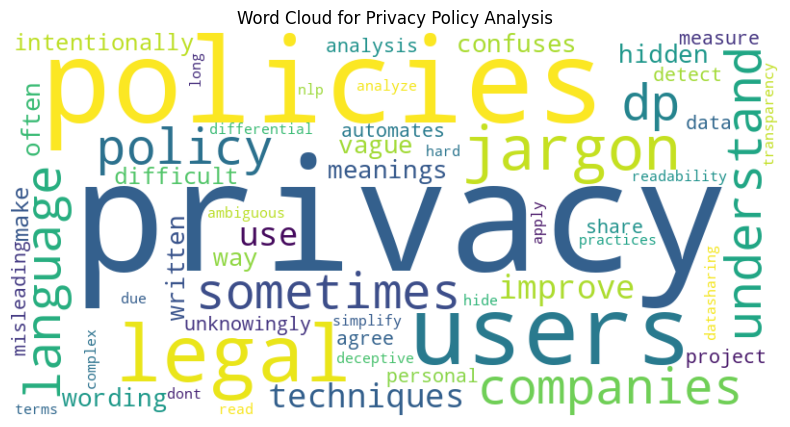

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# Extract the text from the document (assuming it's provided as plain text)
privacy_policy_text = """
Privacy policies are often written in a way that confuses users with legal jargon, vague wording,
and hidden meanings. Companies sometimes intentionally make their policies difficult to
understand so that users unknowingly agree to share their personal data.

This project automates privacy policy analysis to detect misleading language, measure
readability, and apply Differential Privacy (DP) techniques to improve policy transparency.

• Privacy policies are hard to understand due to legal jargon and ambiguous terms.
• Companies sometimes use deceptive language to hide data-sharing practices.
• Users don’t read privacy policies because they are long and complex.
• We use NLP & DP techniques to analyze, simplify, and improve privacy policies.
"""

# Preprocess the text: remove special characters and convert to lowercase
processed_text = re.sub(r'[^a-zA-Z\s]', '', privacy_policy_text.lower())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(processed_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide the axes
plt.title("Word Cloud for Privacy Policy Analysis")
plt.show()
